In [1]:
!pip install -U evaluate sacrebleu accelerate wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 52.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import DatasetDict, Dataset
from datasets import load_dataset

import transformers
from transformers import TextDataset, DataCollatorForLanguageModeling
# from transformers import DataCollatorForSeq2Seq
from transformers import GPT2Tokenizer, GPT2LMHeadModel
# from transformers import Trainer, TrainingArguments
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

import evaluate
import accelerate

In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['PYTORCH_USE_CUDA_DSA'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [10]:
checkpoint = "DezS/Accent-and-accentless-Vietnamese-dataset"
raw_dataset = load_dataset(checkpoint)

In [7]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['Sentences', 'AccentlessSentences'],
        num_rows: 4036379
    })
})

In [13]:
reduced_size = int(len(raw_dataset["train"]) // 5) # raw data로 학습 시 에포크 1개 당 15시간이 걸린다는 단점이 있다.
print(f"reduced_size: {reduced_size}")

raw_dataset["train"] = raw_dataset["train"].shuffle(seed=42).select(range(reduced_size))

reduced_size: 807275


In [14]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['Sentences', 'AccentlessSentences'],
        num_rows: 807275
    })
})

Text(0, 0.5, 'Frequency')

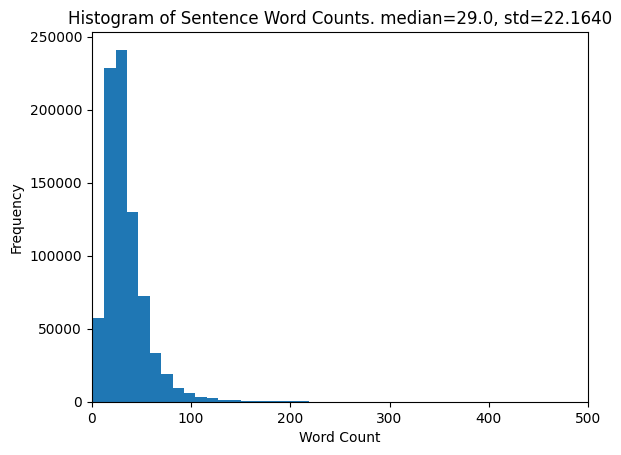

In [15]:
sentences_word_counts = [len(sentence.split()) for sentence in raw_dataset['train']['Sentences']]
plt.hist(sentences_word_counts, bins=100)
plt.title(f"Histogram of Sentence Word Counts. median={np.median(sentences_word_counts)}, std={np.std(sentences_word_counts):.4f}")
plt.xlim([0, 500])
plt.xlabel("Word Count")
plt.ylabel("Frequency")

In [16]:
# 남아있는 성조를 모두 제거

def remove_accents(s):
    s = re.sub(r'[àáạảãâầấậẩẫăằắặẳẵ]', 'a', s)
    s = re.sub(r'[ÀÁẠẢÃĂẰẮẶẲẴÂẦẤẬẨẪ]', 'A', s)
    s = re.sub(r'[èéẹẻẽêềếệểễ]', 'e', s)
    s = re.sub(r'[ÈÉẸẺẼÊỀẾỆỂỄ]', 'E', s)
    s = re.sub(r'[òóọỏõôồốộổỗơờớợởỡ]', 'o', s)
    s = re.sub(r'[ÒÓỌỎÕÔỒỐỘỔỖƠỜỚỢỞỠ]', 'O', s)
    s = re.sub(r'[ìíịỉĩ]', 'i', s)
    s = re.sub(r'[ÌÍỊỈĨ]', 'I', s)
    s = re.sub(r'[ùúụủũưừứựửữ]', 'u', s)
    s = re.sub(r'[ƯỪỨỰỬỮÙÚỤỦŨ]', 'U', s)
    s = re.sub(r'[ỳýỵỷỹ]', 'y', s)
    s = re.sub(r'[ỲÝỴỶỸ]', 'Y', s)
    s = re.sub(r'[Đ]', 'D', s)
    s = re.sub(r'[đ]', 'd', s)
    return s

In [17]:
# 성조 없애기 적용

updated_dataset = raw_dataset.map(lambda example: {"AccentRemovedSentences": remove_accents(example["AccentlessSentences"])},
                                  remove_columns=["AccentlessSentences"],
                                  num_proc=32,
                                  )

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=32):   0%|          | 0/807275 [00:00<?, ? examples/s]

In [18]:
updated_dataset = updated_dataset['train'].train_test_split(test_size=0.2, seed=42)
valid_test_dataset = updated_dataset['test'].train_test_split(test_size=0.5, seed=42)
splitted_dataset = DatasetDict({
    'train': updated_dataset['train'],
    'val': valid_test_dataset['train'],
    'test': valid_test_dataset['test'],
    })
splitted_dataset

DatasetDict({
    train: Dataset({
        features: ['Sentences', 'AccentRemovedSentences'],
        num_rows: 645820
    })
    val: Dataset({
        features: ['Sentences', 'AccentRemovedSentences'],
        num_rows: 80727
    })
    test: Dataset({
        features: ['Sentences', 'AccentRemovedSentences'],
        num_rows: 80728
    })
})

In [19]:
splitted_dataset['train'][0]

{'Sentences': 'Như trong 10 ngày đầu mở cửa, khi du khách vào tham quan nếu không hài lòng, chúng tôi đều sẵn sàng trả toàn bộ tiền vé.',
 'AccentRemovedSentences': 'Nhu trong 10 ngay dau mo cua, khi du khach vao tham quan neu khong hai long, chung toi deu san sang tra toan bo tien ve.'}

In [20]:
tokenizer = GPT2Tokenizer.from_pretrained('NlpHUST/gpt2-vietnamese')

tokenizer_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/854k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/512k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
tokenizer.pad_token = tokenizer.eos_token

In [22]:
def tokenize_function(example):
    result = tokenizer(example["AccentRemovedSentences"], text_target=example["Sentences"],
                       truncation=True, padding='max_length', max_length=200, return_special_tokens_mask=True)
    # del result['special_tokens_mask']
    return result

In [23]:
transformers.logging.set_verbosity_error()

In [24]:
splitted_dataset['val'] = splitted_dataset['val'].map(tokenize_function,
                                                      remove_columns=["Sentences", "AccentRemovedSentences"],
                                                      num_proc=32) # multiprocessing

Map (num_proc=32):   0%|          | 0/80727 [00:00<?, ? examples/s]

In [25]:
splitted_dataset['val']

Dataset({
    features: ['input_ids', 'special_tokens_mask', 'attention_mask', 'labels'],
    num_rows: 80727
})

In [ ]:
splitted_dataset['val'][0]

In [27]:
splitted_dataset['test'] = splitted_dataset['test'].map(tokenize_function,
                                                        remove_columns=["Sentences", "AccentRemovedSentences"],
                                                        num_proc=32)

Map (num_proc=32):   0%|          | 0/80728 [00:00<?, ? examples/s]

In [ ]:
splitted_dataset['test'][0]

In [29]:
splitted_dataset['train'] = splitted_dataset['train'].map(tokenize_function,
                                                          remove_columns=["Sentences", "AccentRemovedSentences"],
                                                          num_proc=32)

Map (num_proc=32):   0%|          | 0/645820 [00:00<?, ? examples/s]

In [ ]:
# splitted_dataset['train'][0]

In [30]:
splitted_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'special_tokens_mask', 'attention_mask', 'labels'],
        num_rows: 645820
    })
    val: Dataset({
        features: ['input_ids', 'special_tokens_mask', 'attention_mask', 'labels'],
        num_rows: 80727
    })
    test: Dataset({
        features: ['input_ids', 'special_tokens_mask', 'attention_mask', 'labels'],
        num_rows: 80728
    })
})

In [31]:
from huggingface_hub import notebook_login

notebook_login()

In [32]:
splitted_dataset.push_to_hub("cacbon-dioxit/Vietnamese-Accent-Removed-Sampled-dataset", private=True)

Uploading the dataset shards:   0%|          | 0/4 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/162 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/162 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/162 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/162 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/81 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/81 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/cacbon-dioxit/Vietnamese-Accent-Removed-Sampled-dataset/commit/40951556b17cfd3b03a164e98a714104c739db53', commit_message='Upload dataset', commit_description='', oid='40951556b17cfd3b03a164e98a714104c739db53', pr_url=None, pr_revision=None, pr_num=None)